### Subset Region Figure and Station List Generator
The following script is used to identify stations within a specific geographic region (counties, spatial extent) and produce simple maps of their location. These can be produced for one-off requests. 
Examples:
- Santa Clara subset for precipitation sensors, for VW
- San Diego subset for hypothetical station replacement, for CEC

In [1]:
# import libraries
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as cx
import cartopy.crs as ccrs
from qaqc_utils import *

%matplotlib inline

In [2]:
from shapely.geometry import Point, Polygon
from pyproj import CRS, Transformer

# Helper function for plotting
def latlon_to_mercator_cartopy(lat, lon):
    proj_latlon = CRS('EPSG:4326')
    proj_mercator = CRS('EPSG:3857')
    
    # Transform the coordinates
    transformer = Transformer.from_crs(proj_latlon, proj_mercator, always_xy=True)
    x,y = transformer.transform(lon, lat)
    
    return x, y

# Shapefile of CA counties, for subsetting for a specific area
ca_counties = gpd.read_file("s3://wecc-historical-wx/0_maps/ca_counties/CA_Counties.shp" )

In [3]:
# Read in all stations
df_all = pd.read_csv("s3://wecc-historical-wx/2_clean_wx/temp_clean_all_station_list.csv")

# Subset for cleaned stations (Y flag)
df_clean = df_all.loc[df_all['cleaned'] == 'Y']
df_clean.head(5)

,Unnamed: 0,era-id,longitude,latitude,elevation,start-date,end-date,cleaned,time_cleaned,network,...,pr_nobs,pr_5min_nobs,pr_1h_nobs,pr_24h_nobs,pr_localmid_nobs,hurs_nobs,sfcwind_nobs,sfcwind_dir_nobs,rsds_nobs,total_nobs
0,0,ASOSAWOS_69007093217,-121.767,36.683,-30479.6952,1960-04-04 00:00:00+00:00,1993-08-31 00:00:00+00:00,Y,2023-02-07 04:04:27+00:00,ASOSAWOS,...,2695.0,0.0,0.0,0.0,0.0,0.0,14267.0,12124.0,0.0,14269.0
1,1,ASOSAWOS_69023024255,-122.667,48.350,14.3256,1989-12-01 00:00:00+00:00,1997-12-31 00:00:00+00:00,Y,2023-02-07 07:46:18+00:00,ASOSAWOS,...,43976.0,0.0,0.0,0.0,0.0,0.0,187878.0,162013.0,0.0,198355.0
2,2,ASOSAWOS_69960403145,-114.617,32.650,64.9224,1987-07-01 00:00:00+00:00,1997-12-31 00:00:00+00:00,Y,2023-02-07 07:40:55+00:00,ASOSAWOS,...,28206.0,0.0,0.0,0.0,0.0,0.0,149695.0,128239.0,0.0,157070.0
3,3,ASOSAWOS_72012200114,-113.117,48.600,1419.1488,2014-07-31 00:00:00+00:00,2015-09-30 00:00:00+00:00,Y,2023-02-07 13:14:14+00:00,ASOSAWOS,...,0.0,0.0,0.0,0.0,0.0,0.0,18663.0,17496.0,0.0,18666.0
4,4,ASOSAWOS_72019300117,-122.922,40.747,716.2800,2010-10-30 00:00:00+00:00,2020-08-12 00:00:00+00:00,Y,2023-02-07 12:39:56+00:00,ASOSAWOS,...,11505.0,0.0,0.0,0.0,0.0,0.0,210460.0,90525.0,0.0,210563.0


#### Example of subsetting for a variable + region
Looking at stations in the Santa Clara region for precipitation sensors

In [4]:
# Pick specific county
target_county = ca_counties[ca_counties['NAME'] == 'Santa Clara']

In [5]:
# Identify stations with precipitation sensors, looking for sensors with more than 5 observations to avoid stations that have a single observation
df_clean_pr = df_clean.loc[(df_clean[['pr_nobs', 'pr_5min_nobs', 'pr_1h_nobs', 'pr_24h_nobs', 'pr_localmid_nobs']] > 5).any(axis=1)]
df_clean_pr

# Option to output the subsetted stations with precip
df_clean_pr.to_csv('histobs_stns_all_precip.csv')

In [10]:
# Set up a map
geometry = [Point(latlon_to_mercator_cartopy(lat,lon)) for lat,lon in zip (df_clean.latitude, df_clean.longitude)]
pr_stns = gpd.GeoDataFrame(df_clean, geometry=geometry).set_crs(crs="EPSG:3857", allow_override=True) # adding geometry column
pr_stns = gpd.overlay(pr_stns, target_county, how="intersection") # subsetting for stations within county boundaries
print(f'Number of stations: {len(pr_stns)}')

Number of stations: 250


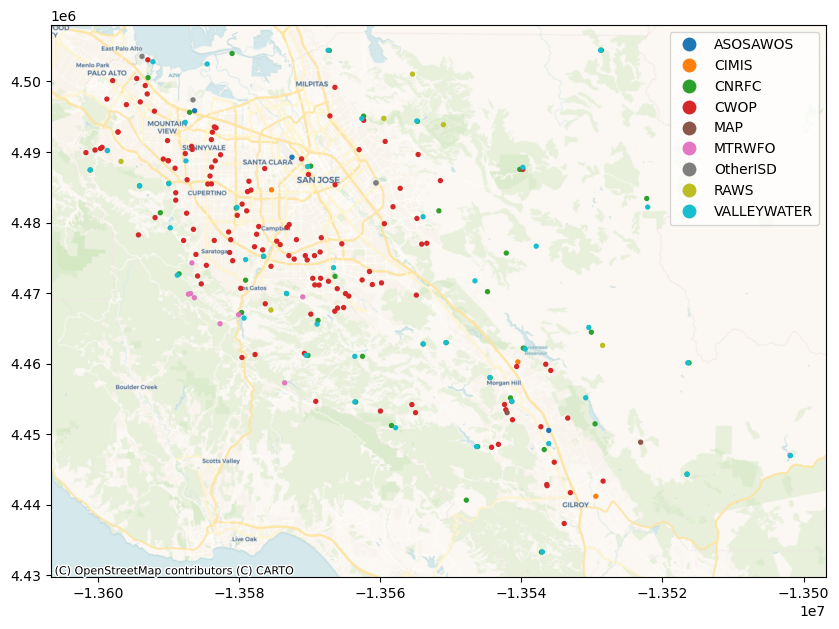

In [9]:
# Mapping
ax = pr_stns.plot(column='network', markersize=8, legend=True, figsize=(10,10))
cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager)

# Also, can use your geodataframe and .explore() to zoom around
## pr_stns.explore()

#### Example of subsetting for a specific region + network
Looking at sensors in San Diego county, and specific networks

In [11]:
# Pick specific county
target_county = ca_counties[ca_counties['NAME'] == 'San Diego']

In [12]:
# Subset for those stations
geometry = [Point(latlon_to_mercator_cartopy(lat,lon)) for lat,lon in zip (df_clean.latitude, df_clean.longitude)]
sd_stns = gpd.GeoDataFrame(df_clean, geometry=geometry).set_crs(crs="EPSG:3857", allow_override=True) # adding geometry column
sd_stns = gpd.overlay(sd_stns, target_county, how="intersection") # subsetting for stations within county boundaries
print(f'Number of stations: {len(sd_stns)}')

# Option to export 
sd_stns = df_all.loc[df_all['era-id'].isin(sd_stns['era-id'])]
sd_stns.to_csv('histobs_stns_san_diego_county.csv')

Number of stations: 521


In [ ]:
# Subset for specific network
sd_stns = sd_stns.loc[(sd_stns['network'] == 'OtherISD') | (sd_stns['network'] == 'ASOSAWOS')]
sd_stns

In [ ]:
# Mapping
ax = sd_stns.plot(column='network', markersize=8, legend=True, figsize=(10,10))
cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager)